In [33]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['legend.fontsize']=12
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 5
plt.rcParams['axes.labelsize'] = 14

In [2]:
import numpy as np
import pickle

from DDAS import MakeReal
from AntennaSelection import generateLROASdata, generateOASdata, generateSASdata, calculateBERwithAS, AntennaSelector
from symbols import SymbolGenerator, MLdecoder
from channels import MIMOChannelUncorrelatedGaussian

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.base import clone

In [3]:
data_prep_pipeline = Pipeline([
    ('toReal', MakeReal(RealPart = False, ImaginaryPart=False, magnitude = True, Phase = False)),
    ('stdScaler', StandardScaler()),
])

In [4]:
Nt = 200
Nr = 100

snr = np.array([0,5,10])
print(snr)

[ 0  5 10]


In [5]:
Ro = np.linspace(0,2,21)
print(Ro)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2. ]


In [6]:
import math

def secrecyRate(chU, chE, snrU, snrE):
    U = chU.getChannel()
    U = np.abs(U)
    U = np.square(U)
    Guser = np.sum(U)* (10**(snrU/10))
    
    E = chE.getChannel()
    E = np.abs(E)
    E = np.square(E)
    Geve = np.sum(E)* (10**(snrE/10))

    Cs = math.log2(1+Guser) - math.log2(1 + Geve)
    
    return Cs

In [7]:
def outageProbability(snrU,snrE, R, nt=1, nr=1, n=50000, selection='OAS'):
    p = np.zeros(len(R))
    for i in range(len(R)):
        for j in range(n):
            chU = MIMOChannelUncorrelatedGaussian(nt,nr)
            chE = MIMOChannelUncorrelatedGaussian(nt,nr)
            AS = AntennaSelector(chU, chE)
            if(selection == 'OAS'):
                s = AS.OptimalAntennaSelection()
            elif(selection == 'SAS'):
                s = AS.SuboptimalAntennaSelection()
            elif(selection == 'LROAS'):
                s = AS.LinearReceiverAntennaSelection()
            else:
                raise ValueError('Invalid method: {}'.format(selection))
            
            chU.setSubchannel(s)
            chE.setSubchannel(s)
            
            cs = secrecyRate(chU,chE,snrU,snrE)

            if(cs <= R[i]):
                p[i] += 1
        
        p[i] = p[i]/n
    
    return p

In [8]:
op1 = outageProbability(5,0, Ro, nt = 1, nr = 10, selection='OAS')
# op2 = outageProbability(10,0, Ro, nt = 1, nr = 10, selection='OAS')

op3 = outageProbability(5,0, Ro, nt = 2, nr = 10, selection='OAS')
# op4 = outageProbability(10,0, Ro, nt = 2, nr = 10, selection='OAS')

op5 = outageProbability(5,0, Ro, nt = 4, nr = 10, selection='OAS')
# op6 = outageProbability(10,0, Ro, nt = 4, nr = 10, selection='OAS')

In [9]:
sp1 = outageProbability(5,0, Ro, nt = 1, nr = 10, selection='SAS')
# sp2 = outageProbability(10,0, Ro, nt = 1, nr = 10, selection='SAS')

sp3 = outageProbability(5,0, Ro, nt = 2, nr = 10, selection='SAS')
# sp4 = outageProbability(10,0, Ro, nt = 2, nr = 10, selection='SAS')

sp5 = outageProbability(5,0, Ro, nt = 4, nr = 10, selection='SAS')
# sp6 = outageProbability(10,0, Ro, nt = 4, nr = 10, selection='SAS')

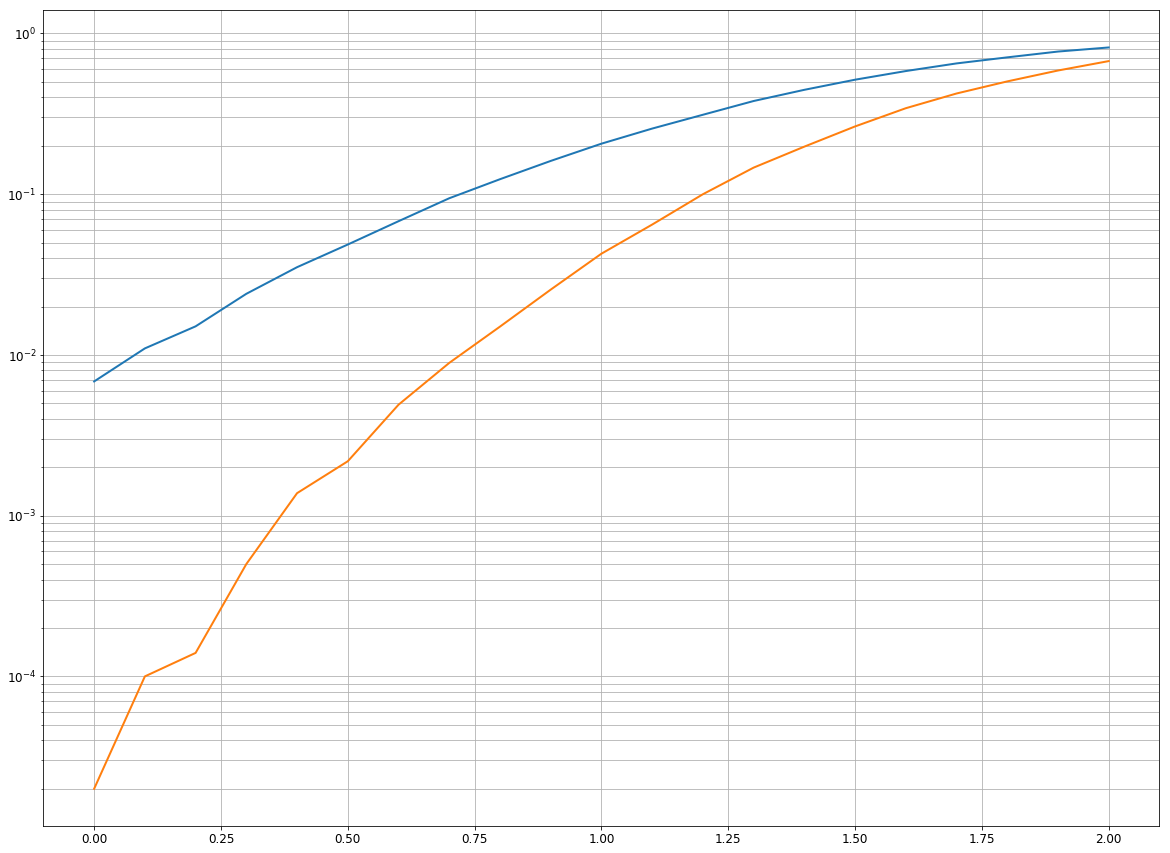

In [10]:
plt.figure(figsize=(20,15))
plt.semilogy(Ro,op1)
plt.semilogy(Ro,op3)
# plt.semilogy(Ro,op3)
# plt.semilogy(Ro,op4)
# plt.semilogy(Ro,op5)
# plt.semilogy(Ro,op6)

# plt.semilogy(Ro,sp1)
# plt.semilogy(Ro,sp2)
# plt.semilogy(Ro,sp3)
# plt.semilogy(Ro,sp4)
# plt.semilogy(Ro,sp5)
# plt.semilogy(Ro,sp6)

plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')

plt.show()

In [8]:
import numbers

def outageProbabilityModel(model, pipeline, snrU,snrE, R, nt=1, nr=1, n=50000, selection='OAS'):
    p = np.zeros(len(R))
    for i in range(len(R)):
        for j in range(n):
            chU = MIMOChannelUncorrelatedGaussian(nt,nr)
            chE = MIMOChannelUncorrelatedGaussian(nt,nr)
            AS = AntennaSelector(chU, chE)
            
            if(selection == 'OAS'):
                H = np.concatenate((chU.getChannel().flatten().reshape(1,-1), chE.getChannel().flatten().reshape(1,-1)), axis=1)
                s = model.predict(pipeline.transform(H))
            elif(selection == 'SAS'):
                H = chU.getChannel().flatten().reshape(1,-1)
                s = model.predict(pipeline.transform(H))
            elif(selection == 'LROAS'):
                raise ValueError('LROAS not supported yet')
            else:
                raise ValueError('Invalid method: {}'.format(selection))
            s = np.array(s,dtype=int)
#             print('1', s)
#             if(isinstance(s, numbers.Number)):
#                 s = np.array(s, dtype = int)
#             else:
#                 s = s.astype(int)
#                 ss = s.flatten()
#                 s = []
#                 for j in ss:
#                     if(j==0):
#                         continue
#                     else:
#                         s.append(j)
#                 s = np.array(s, dtype=int)
#                 s = s.flatten()
#             print(s)
            chU.setSubchannel(s)
            chE.setSubchannel(s)
            
            cs = secrecyRate(chU,chE,snrU,snrE)

            if(cs <= R[i]):
                p[i] += 1
        
        p[i] = p[i]/n
    
    return p

# Empirical Outage Probability

## OAS

### Nt = 2

In [12]:
Nt = 2
Nr = 10

X,y = generateOASdata(50000,nt=Nt,nr=Nr)

X = data_prep_pipeline.fit_transform(X)
mlpc_clf = MLPClassifier(max_iter=1000)
mlpc_clf.fit(X,y)

mop3 = outageProbabilityModel(mlpc_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='OAS' )
# mop4 = outageProbabilityModel(mlpc_clf, data_prep_pipeline,10,0, Ro, nt = Nt, nr = 10, selection='OAS' )

In [13]:
Nt = 2
Nr = 10

X,y = generateOASdata(10000,nt=Nt,nr=Nr)


X = data_prep_pipeline.fit_transform(X)
svc_clf = SVC()
svc_clf.fit(X,y)

svcop3 = outageProbabilityModel(svc_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='OAS' )
# svcop4 = outageProbabilityModel(svc_clf, data_prep_pipeline,10,0, Ro, nt = Nt, nr = 10, selection='OAS' )

In [25]:
Nt = 2
Nr = 10

X,y = generateOASdata(10000,nt=Nt,nr=Nr)
X = data_prep_pipeline.fit_transform(X)

knn_clf = KNeighborsClassifier(n_neighbors= 51)
knn_clf.fit(X,y)

knnop3 = outageProbabilityModel(knn_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='OAS' )
# knnop4 = outageProbabilityModel(knn_clf, data_prep_pipeline,10,0, Ro, nt = Nt, nr = 10, selection='OAS' )

### Nt = 4

In [15]:
Nt = 4
Nr = 10

X,y = generateOASdata(100000,nt=Nt,nr=Nr)


X = data_prep_pipeline.fit_transform(X)
mlpc_clf = MLPClassifier(max_iter=1000)
mlpc_clf.fit(X,y)

mop5 = outageProbabilityModel(mlpc_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='OAS' )
# mop6 = outageProbabilityModel(mlpc_clf, data_prep_pipeline,10,0, Ro, nt = Nt, nr = 10, selection='OAS' )

In [16]:
Nt = 4
Nr = 10

X,y = generateOASdata(10000,nt=Nt,nr=Nr)

X = data_prep_pipeline.fit_transform(X)
svc_clf = SVC()
svc_clf.fit(X,y)

svcop5 = outageProbabilityModel(svc_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='OAS' )
# svcop6 = outageProbabilityModel(svc_clf, data_prep_pipeline,10,0, Ro, nt = Nt, nr = 10, selection='OAS' )

In [26]:
Nt = 4
Nr = 10

X,y = generateOASdata(10000,nt=Nt,nr=Nr)
X = data_prep_pipeline.fit_transform(X)

knn_clf = KNeighborsClassifier(n_neighbors= 51)
knn_clf.fit(X,y)

knnop5 = outageProbabilityModel(knn_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='OAS' )
# knnop6 = outageProbabilityModel(knn_clf, data_prep_pipeline,10,0, Ro, nt = Nt, nr = 10, selection='OAS' )

## SAS

### Nt =2

In [18]:
Nt = 2
Nr = 10

X,y = generateSASdata(50000,nt=Nt,nr=Nr)


X = data_prep_pipeline.fit_transform(X)
mlpc_clf = MLPClassifier(max_iter=1000)
mlpc_clf.fit(X,y)

msp3 = outageProbabilityModel(mlpc_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='SAS' )
# msp4 = outageProbabilityModel(mlpc_clf, data_prep_pipeline,10,0, Ro, nt = Nt, nr = 10, selection='SAS' )

In [19]:
Nt = 2
Nr = 10

X,y = generateSASdata(10000,nt=Nt,nr=Nr)


X = data_prep_pipeline.fit_transform(X)
svc_clf = SVC()
svc_clf.fit(X,y)

svcsp3 = outageProbabilityModel(svc_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='SAS' )
# svcop4 = outageProbabilityModel(svc_clf, data_prep_pipeline,10,0, Ro, nt = Nt, nr = 10, selection='SAS' )

In [27]:
Nt = 2
Nr = 10

X,y = generateSASdata(10000,nt=Nt,nr=Nr)
X = data_prep_pipeline.fit_transform(X)

knn_clf = KNeighborsClassifier(n_neighbors= 51)
knn_clf.fit(X,y)

knnsp3 = outageProbabilityModel(knn_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='SAS' )
# knnop4 = outageProbabilityModel(knn_clf, data_prep_pipeline,10,0, Ro, nt = Nt, nr = 10, selection='SAS' )

### Nt = 4

In [21]:
Nt = 4
Nr = 10

X,y = generateSASdata(50000,nt=Nt,nr=Nr)


X = data_prep_pipeline.fit_transform(X)
mlpc_clf = MLPClassifier(max_iter=1000)
mlpc_clf.fit(X,y)

msp5 = outageProbabilityModel(mlpc_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='SAS' )
# msp6 = outageProbabilityModel(mlpc_clf, data_prep_pipeline,10,0, Ro, nt = Nt, nr = 10, selection='SAS' )

In [22]:
Nt = 4
Nr = 10

X,y = generateSASdata(10000,nt=Nt,nr=Nr)

X = data_prep_pipeline.fit_transform(X)
svc_clf = SVC()
svc_clf.fit(X,y)

svcsp5 = outageProbabilityModel(svc_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='SAS' )
# svcsp6 = outageProbabilityModel(svc_clf, data_prep_pipeline,10,0, Ro, nt = Nt, nr = 10, selection='SAS' )

In [23]:
svcsp5[0]

2e-05

In [28]:
Nt = 4
Nr = 10

X,y = generateSASdata(10000,nt=Nt,nr=Nr)

X = data_prep_pipeline.fit_transform(X)

knn_clf = KNeighborsClassifier(n_neighbors= 51)
knn_clf.fit(X,y)

knnsp5 = outageProbabilityModel(knn_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='SAS' )
# knnsp6 = outageProbabilityModel(knn_clf, data_prep_pipeline,10,0, Ro, nt = Nt, nr = 10, selection='SAS' )

In [25]:
output = open('./OutageProbabilities/op1','wb')
pickle.dump(op1, output)
output = open('./OutageProbabilities/op3','wb')
pickle.dump(op3, output)
output = open('./OutageProbabilities/op5','wb')
pickle.dump(op5, output)

In [26]:
output = open('./OutageProbabilities/sp1','wb')
pickle.dump(sp1, output)
output = open('./OutageProbabilities/sp3','wb')
pickle.dump(sp3, output)
output = open('./OutageProbabilities/sp5','wb')
pickle.dump(sp5, output)

In [27]:
output = open('./OutageProbabilities/mop3','wb')
pickle.dump(mop3, output)
output = open('./OutageProbabilities/mop5','wb')
pickle.dump(mop5, output)

In [28]:
output = open('./OutageProbabilities/msp3','wb')
pickle.dump(msp3, output)
output = open('./OutageProbabilities/msp5','wb')
pickle.dump(msp5, output)

In [29]:
output = open('./OutageProbabilities/svcop3','wb')
pickle.dump(svcop3, output)
output = open('./OutageProbabilities/svcop5','wb')
pickle.dump(svcop5, output)

In [30]:
output = open('./OutageProbabilities/svcsp3','wb')
pickle.dump(svcsp3, output)
output = open('./OutageProbabilities/svcsp5','wb')
pickle.dump(svcsp5, output)

In [29]:
output = open('./OutageProbabilities/knnop3','wb')
pickle.dump(knnop3, output)
output = open('./OutageProbabilities/knnop5','wb')
pickle.dump(knnop5, output)

In [30]:
output = open('./OutageProbabilities/knnsp3','wb')
pickle.dump(knnsp3, output)
output = open('./OutageProbabilities/knnsp5','wb')
pickle.dump(knnsp5, output)

# Load Data

In [9]:
output = open('./OutageProbabilities/op1','rb')
op1 = pickle.load(output)
output = open('./OutageProbabilities/op3','rb')
op3 = pickle.load( output)
output = open('./OutageProbabilities/op5','rb')
op5 = pickle.load( output)

In [10]:
output = open('./OutageProbabilities/sp1','rb')
sp1 = pickle.load(output)
output = open('./OutageProbabilities/sp3','rb')
sp3 = pickle.load(output)
output = open('./OutageProbabilities/sp5','rb')
sp5 = pickle.load(output)

In [11]:
output = open('./OutageProbabilities/mop3','rb')
mop3 = pickle.load(output)
output = open('./OutageProbabilities/mop5','rb')
mop5 = pickle.load(output)

In [12]:
output = open('./OutageProbabilities/msp3','rb')
msp3 = pickle.load(output)
output = open('./OutageProbabilities/msp5','rb')
msp5 = pickle.load(output)

In [13]:
output = open('./OutageProbabilities/svcop3','rb')
svcop3  = pickle.load(output)
output = open('./OutageProbabilities/svcop5','rb')
svcop5 = pickle.load(output)

In [14]:
output = open('./OutageProbabilities/svcsp3','rb')
svcsp3 = pickle.load(output)
output = open('./OutageProbabilities/svcsp5','rb')
svcsp5 = pickle.load(output)

In [15]:
output = open('./OutageProbabilities/knnop3','rb')
knnop3 = pickle.load(output)
output = open('./OutageProbabilities/knnop5','rb')
knnop5 = pickle.load(output)

In [16]:
output = open('./OutageProbabilities/knnsp3','rb')
knnsp3 = pickle.load(output)
output = open('./OutageProbabilities/knnsp5','rb')
knnsp5 = pickle.load(output)

In [11]:
plt.figure(figsize=(20,15))
plt.semilogy(Ro, mop3)
plt.semilogy(Ro, mop5)

NameError: name 'Ro' is not defined

<Figure size 1440x1080 with 0 Axes>

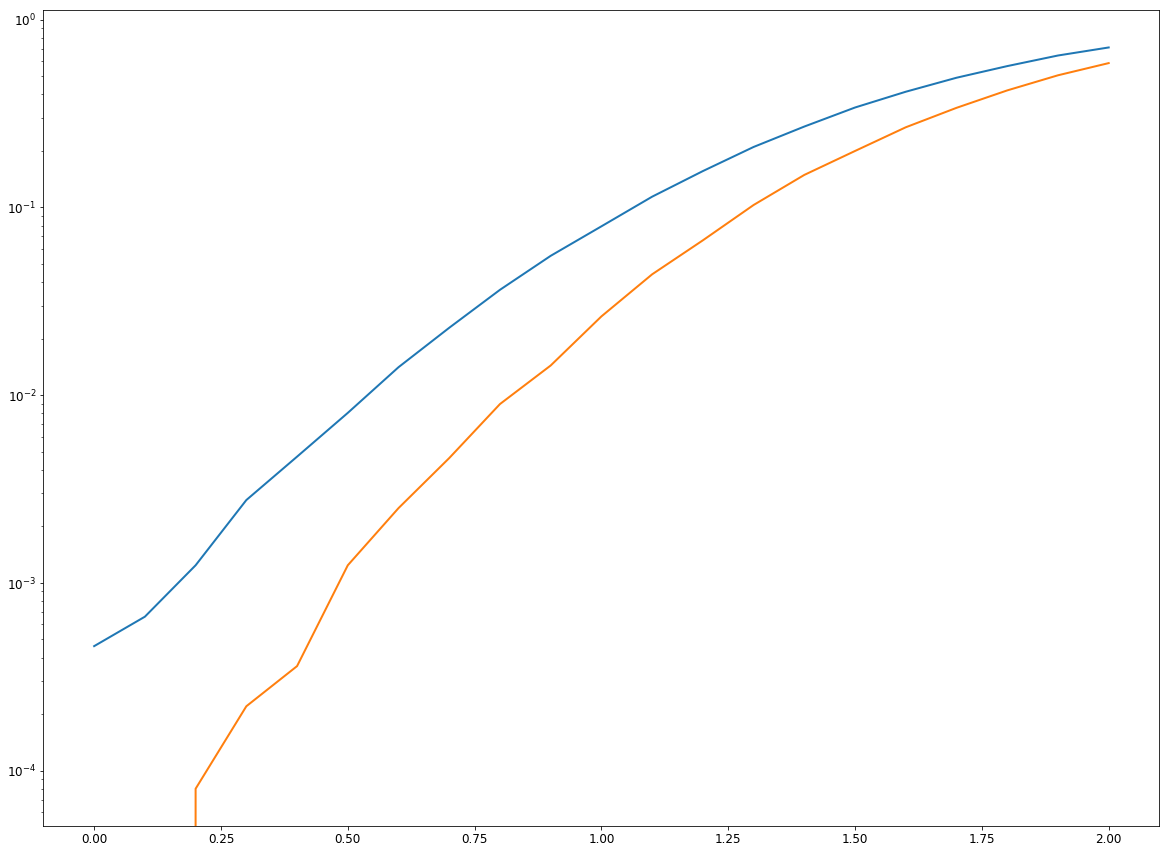

In [14]:
plt.figure(figsize=(20,15))
plt.semilogy(Ro, msp3)
plt.semilogy(Ro, msp5)

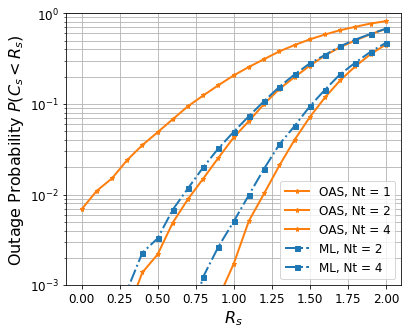

In [15]:
plt.figure(figsize=(6,5))

plt.semilogy(Ro,op1, 'C1*-', label='OAS, Nt = 1')
plt.semilogy(Ro,op3, 'C1*-', label='OAS, Nt = 2')
plt.semilogy(Ro,op5, 'C1*-', label='OAS, Nt = 4')


# plt.semilogy(Ro,mop1, 'C0s-.', label='ML, Nt = 1')
plt.semilogy(Ro,mop3, 'C0s-.', label='ML, Nt = 2')
plt.semilogy(Ro,mop5, 'C0s-.', label='ML, Nt = 4')



plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')

plt.ylim([10**-3, 1])
plt.legend()
plt.xlabel('$R_s$')
plt.ylabel('Outage Probability $P(C_s < R_s)$')
plt.show()

NameError: name 'msp1' is not defined

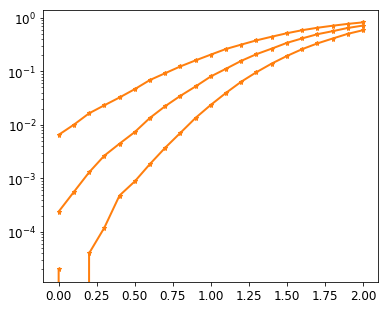

In [45]:
plt.figure(figsize=(6,5))

plt.semilogy(Ro,sp1, 'C1*-', label='SAS, Nt = 1')
plt.semilogy(Ro,sp3, 'C1*-', label='SAS, Nt = 2')
plt.semilogy(Ro,sp5, 'C1*-', label='SAS, Nt = 4')


plt.semilogy(Ro,msp1, 'C0s-.', label='ML, Nt = 1')
plt.semilogy(Ro,msp3, 'C0s-.', label='ML, Nt = 2')
plt.semilogy(Ro,msp5, 'C0s-.', label='ML, Nt = 4')



plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')

plt.ylim([10**-3, 1])
plt.legend()
plt.xlabel('$R_s$')
plt.ylabel('Outage Probability $P(C_s < R_s)$')
plt.show()

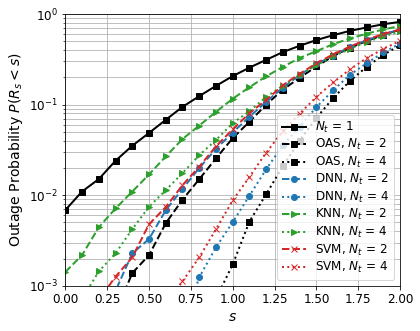

In [40]:
plt.figure(figsize=(6,5))

plt.semilogy(Ro,op1, 'ks-', label='$N_t$ = 1')
plt.semilogy(Ro,op3, 'ks--', label='OAS, $N_t$ = 2')
plt.semilogy(Ro,op5, 'ks:', label='OAS, $N_t$ = 4')


plt.semilogy(Ro,mop3, 'C0o--', label='DNN, $N_t$ = 2')
plt.semilogy(Ro,mop5, 'C0o:', label='DNN, $N_t$ = 4')

plt.semilogy(Ro,knnop3, 'C2>--', label='KNN, $N_t$ = 2')
plt.semilogy(Ro,knnop5, 'C2>:', label='KNN, $N_t$ = 4')

plt.semilogy(Ro,svcop3, 'C3x--', label='SVM, $N_t$ = 2')
plt.semilogy(Ro,svcop5, 'C3x:', label='SVM, $N_t$ = 4')


plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')

plt.ylim([10**-3, 1])
plt.xlim([0, 2])
plt.legend(labelspacing=0.2)
plt.xlabel('$s$')
plt.ylabel('Outage Probability $P(R_s < s)$')

plt.savefig('/home/markos/Desktop/paper/oas.eps', format='eps', dpi=1000, bbox_inches='tight')


plt.show()

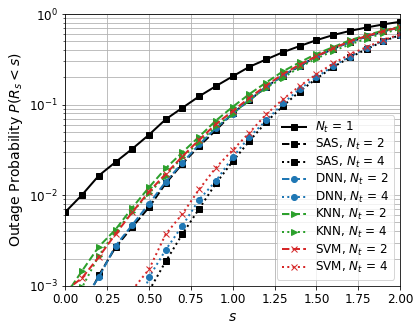

In [39]:
plt.figure(figsize=(6,5))

plt.semilogy(Ro,sp1, 'ks-', label='$N_t$ = 1')
plt.semilogy(Ro,sp3, 'ks--', label='SAS, $N_t$ = 2')
plt.semilogy(Ro,sp5, 'ks:', label='SAS, $N_t$ = 4')


plt.semilogy(Ro,msp3, 'C0o--', label='DNN, $N_t$ = 2')
plt.semilogy(Ro,msp5, 'C0o:', label='DNN, $N_t$ = 4')

plt.semilogy(Ro,knnsp3, 'C2>--', label='KNN, $N_t$ = 2')
plt.semilogy(Ro,knnsp5, 'C2>:', label='KNN, $N_t$ = 4')

plt.semilogy(Ro,svcsp3, 'C3x--', label='SVM, $N_t$ = 2')
plt.semilogy(Ro,svcsp5, 'C3x:', label='SVM, $N_t$ = 4')


plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')

plt.ylim([10**-3, 1])
plt.xlim([0,2])
plt.legend(labelspacing=0.2)
plt.xlabel('$s$')
plt.ylabel('Outage Probability $P(R_s < s)$')

plt.savefig('/home/markos/Desktop/paper/sas.eps', format='eps', dpi=1000, bbox_inches='tight')

plt.show()

# Improvement of NN with increasing training size

In [47]:
Nt = 4
Nr = 10

X,y = generateOASdata(1000000,nt=Nt,nr=Nr)

X = data_prep_pipeline.fit_transform(X)

mlpc_clf = MLPClassifier(max_iter=1000)
mlpc_clf.fit(X,y)

dnn_1m = outageProbabilityModel(mlpc_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='OAS' )

#train with 100k data points

mlpc_clf = MLPClassifier(max_iter=1000)
mlpc_clf.fit(X[:500000],y[:500000])

dnn_500k = outageProbabilityModel(mlpc_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='OAS' )

mlpc_clf = MLPClassifier(max_iter=1000)
mlpc_clf.fit(X[:100000],y[:100000])

dnn_100k = outageProbabilityModel(mlpc_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='OAS' )

mlpc_clf = MLPClassifier(max_iter=1000)
mlpc_clf.fit(X[:50000],y[:50000])

dnn_50k = outageProbabilityModel(mlpc_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='OAS' )

mlpc_clf = MLPClassifier(max_iter=1000)
mlpc_clf.fit(X[:10000],y[:10000])

dnn_10k = outageProbabilityModel(mlpc_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='OAS' )


mlpc_clf = MLPClassifier(max_iter=1000)
mlpc_clf.fit(X[:1000],y[:1000])

dnn_1k = outageProbabilityModel(mlpc_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='OAS' )

In [44]:
X,y = generateOASdata(1000,nt=Nt,nr=Nr)
X = data_prep_pipeline.fit_transform(X)
mlpc_clf = MLPClassifier(max_iter=1000)
mlpc_clf.fit(X[:1000],y[:1000])

dnn_1k = outageProbabilityModel(mlpc_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='OAS' )

In [45]:
output = open('./OutageProbabilities/dnn_1m','wb')
pickle.dump(dnn_1m, output)
output = open('./OutageProbabilities/dnn_500k','wb')
pickle.dump(dnn_500k, output)
output = open('./OutageProbabilities/dnn_100k','wb')
pickle.dump(dnn_100k, output)
output = open('./OutageProbabilities/dnn_50k','wb')
pickle.dump(dnn_50k, output)
output = open('./OutageProbabilities/dnn_10k','wb')
pickle.dump(dnn_10k, output)
output = open('./OutageProbabilities/dnn_1k','wb')
pickle.dump(dnn_1k, output)

In [20]:
output = open('./OutageProbabilities/dnn_1m','rb')
dnn_1m = pickle.load(output)
output = open('./OutageProbabilities/dnn_500k','rb')
dnn_500k = pickle.load(output)
output = open('./OutageProbabilities/dnn_100k','rb')
dnn_100k = pickle.load(output)
output = open('./OutageProbabilities/dnn_50k','rb')
dnn_50k = pickle.load(output)
output = open('./OutageProbabilities/dnn_10k','rb')
dnn_10k = pickle.load(output)
output = open('./OutageProbabilities/dnn_1k','rb')
dnn_1k = pickle.load(output)

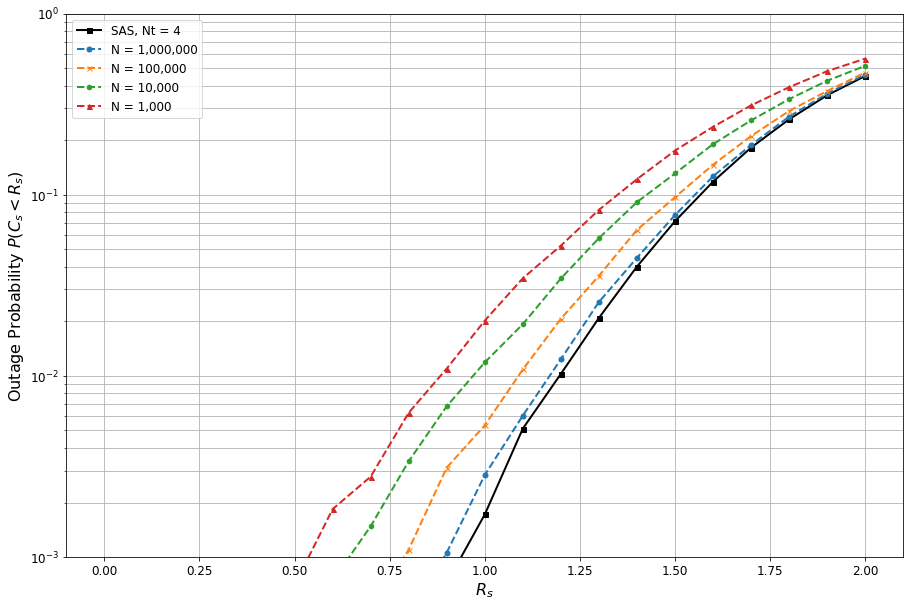

In [21]:
plt.figure(figsize=(15,10))

# plt.semilogy(Ro,op1, 'ks-', label='SAS, Nt = 1')
plt.semilogy(Ro,op5, 'ks-', label='SAS, Nt = 4')


plt.semilogy(Ro,dnn_1m, 'C0o--', label='N = 1,000,000')
# plt.semilogy(Ro,dnn_500k, 'C0^--', label='N = 500,000')
plt.semilogy(Ro,dnn_100k, 'C1x--', label='N = 100,000')
# plt.semilogy(Ro,dnn_50k, 'C0>--', label='N = 50,000')
plt.semilogy(Ro,dnn_10k, 'C2h--', label='N = 10,000')
plt.semilogy(Ro,dnn_1k, 'C3^--', label='N = 1,000')



plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')

plt.ylim([10**-3, 1])
plt.legend()
plt.xlabel('$R_s$')
plt.ylabel('Outage Probability $P(C_s < R_s)$')
plt.show()

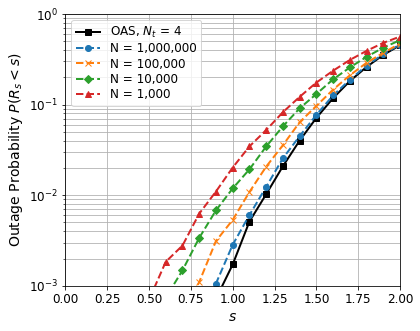

In [41]:
plt.figure(figsize=(6,5))

# plt.semilogy(Ro,op1, 'ks-', label='SAS, Nt = 1')
plt.semilogy(Ro,op5, 'ks-', label='OAS, $N_t$ = 4')


plt.semilogy(Ro,dnn_1m, 'C0o--', label='N = 1,000,000')
# plt.semilogy(Ro,dnn_500k, 'C0^--', label='N = 500,000')
plt.semilogy(Ro,dnn_100k, 'C1x--', label='N = 100,000')
# plt.semilogy(Ro,dnn_50k, 'C0>--', label='N = 50,000')
plt.semilogy(Ro,dnn_10k, 'C2D--', label='N = 10,000')
plt.semilogy(Ro,dnn_1k, 'C3^--', label='N = 1,000')



plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')

plt.ylim([10**-3, 1])
plt.xlim([0,2])
plt.legend(labelspacing=0.2)
plt.xlabel('$s$')
plt.ylabel('Outage Probability $P(R_s < s)$')


plt.savefig('/home/markos/Desktop/paper/datasize.eps', format='eps', dpi=1000, bbox_inches='tight')

plt.show()

# Max  outputs with hidden layer fixed at 100

In [11]:
Nt = 10
Nr = 10

X,y = generateSASdata(1000,nt=Nt,nr=Nr)

X = data_prep_pipeline.fit_transform(X)

mlpc_clf = MLPClassifier(max_iter=1000)
mlpc_clf.fit(X,y)

dnn_10 = outageProbabilityModel(mlpc_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='SAS' )

output = open('./max_output/dnn_10','wb')
pickle.dump(dnn_10, output)

In [12]:
Nt = 100
Nr = 10

X,y = generateSASdata(1000,nt=Nt,nr=Nr)

X = data_prep_pipeline.fit_transform(X)

mlpc_clf = MLPClassifier(max_iter=1000)
mlpc_clf.fit(X,y)

dnn_100 = outageProbabilityModel(mlpc_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='SAS' )

output = open('./max_output/dnn_100','wb')
pickle.dump(dnn_100, output)

In [13]:
Nt = 200
Nr = 10

X,y = generateOASdata(1000,nt=Nt,nr=Nr)

X = data_prep_pipeline.fit_transform(X)

mlpc_clf = MLPClassifier(max_iter=1000)
mlpc_clf.fit(X,y)

dnn_200 = outageProbabilityModel(mlpc_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='OAS' )

output = open('./max_output/dnn_200','wb')
pickle.dump(dnn_200, output)

KeyboardInterrupt: 

In [ ]:
Nt = 500
Nr = 10

X,y = generateOASdata(1000,nt=Nt,nr=Nr)

X = data_prep_pipeline.fit_transform(X)

mlpc_clf = MLPClassifier(max_iter=1000)
mlpc_clf.fit(X,y)

dnn_500 = outageProbabilityModel(mlpc_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='OAS' )

output = open('./max_output/dnn_500','wb')
pickle.dump(dnn_500, output)

In [ ]:
Nt = 1000
Nr = 10

X,y = generateOASdata(1000,nt=Nt,nr=Nr)

X = data_prep_pipeline.fit_transform(X)

mlpc_clf = MLPClassifier(max_iter=1000)
mlpc_clf.fit(X,y)

dnn_1000 = outageProbabilityModel(mlpc_clf, data_prep_pipeline,5,0, Ro, nt = Nt, nr = 10, selection='OAS' )

output = open('./max_output/dnn_1000','wb')
pickle.dump(dnn_1000, output)

NameError: name 'dnn_500' is not defined

NameError: name 'dnn_200' is not defined

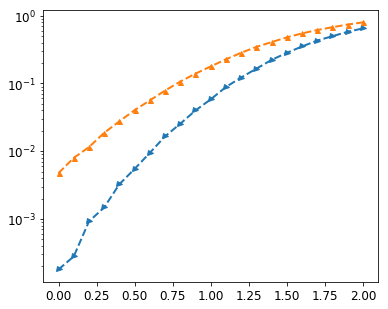

In [14]:
plt.figure(figsize=(6,5))



plt.semilogy(Ro,dnn_10, 'C0>--', label='N_t = 10')
plt.semilogy(Ro,dnn_100, 'C1^--', label='N_t = 100')
plt.semilogy(Ro,dnn_200, 'C2^--', label='N_t = 200')
plt.semilogy(Ro,dnn_500, 'C3^--', label='N_t = 500')
plt.semilogy(Ro,dnn_1000, 'C4^--', label='N_t = 1000')


plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')

plt.ylim([10**-3, 1])
plt.xlim([0,2])
plt.legend()
plt.xlabel('$R_s$')
plt.ylabel('Outage Probability $P(C_s < R_s)$')


plt.savefig('/home/markos/Desktop/paper/Nt.eps', format='eps', dpi=1000, bbox_inches='tight')

plt.show()